In [ ]:
import os
import gc
import time
import pickle
import numpy as np; np.random.seed(42)
import pandas as pd
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import XGBoostForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, compute_weights, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

In [ ]:
logger = open(f"../logs/pipeline-level12-{datetime.now()}", "w")

***
# Input data

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

In [4]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()
encoders["store"]

OrdinalEncoder(cols=['store_id'], drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'store_id', 'data_type': dtype('O'),
                         'mapping': CA_1     1
CA_2     2
CA_3     3
CA_4     4
TX_1     5
TX_2     6
TX_3     7
WI_1     8
WI_2     9
WI_3    10
NaN     -2
dtype: int64}],
               return_df=True, verbose=0)

In [5]:
STORE_ID = 3 # CA_3
data = data.query("store_id == @STORE_ID").reset_index(drop=True)
data.drop(["snap_TX", "snap_WI", "snap_TX_cum", "snap_WI_cum"], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750602 entries, 0 to 4750601
Data columns (total 36 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_CA_cum        int8          
 10  event_name_1       int8          
 11  event_type_1       int8          
 12  event_name_2       int8          
 13  event_type_2       int8          
 14  sell_price         float32       
 15  n_prices           float32       
 16  regular_price      float32       
 17  price_iqr1         float32       
 18  price_iqr2         float32       
 19  price_min          float32       
 20  price_max          float

In [7]:
logger.write(f"\n- only store_id: {STORE_ID}")
logger.flush()

***
# Models configuration

In [8]:
model_params = {
    'objective':'reg:tweedie',
    'tweedie_variance_power':1.1,
    'tree_method':'hist',
    'num_boost_round':100000,
    'early_stopping_rounds':200,
    'max_bin':127,
    'grow_policy':'lossguide',
    'max_leaves':2**9-1,
    'max_depth': 0, 
    'eta': 0.03, 
    'min_child_weight': 2**9-1,
    'colsample_bytree': 0.9,
    'subsample':0.66,
    'lambda':0.1,
    'seed':7,
    'disable_default_eval_metric':1,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "store_id",
    "state_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "prev_newyear",
    "post_newyear",
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    #"lags": list(range(1,15)),
    "window_shifts":[1,7,28,56],
    "window_functions":["mean","median","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{"item_id":"GLMMEncoder", 
                            "dept_id":"GLMMEncoder",
                            "cat_id":"GLMMEncoder",
                            "event_name_1":"GLMMEncoder",
    },
    "ts_uid_columns":["item_id",]
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = [feat for feat in lagged_features if feat not in ["skew", "kurt"]]

In [9]:
logger.write("#"*100+"\n")
logger.write(" MODEL CONFIGURATION ".center(100, "#")+"\n")
logger.write("#"*100+"\n\n")
logger.write(f"- model_params: \n{model_params}\n\n")
logger.write(f"- time_features: \n{model_kwargs['time_features']}\n\n")
if "lags" in model_kwargs.keys():
    logger.write(f"- lags: \n{model_kwargs['lags']}\n\n")
if "window_functions" in model_kwargs.keys():
    logger.write(f"- window_functions: \n{model_kwargs['window_functions']}\n\n")
if "window_shifts" in model_kwargs.keys():
    logger.write(f"- window_shifts: \n{model_kwargs['window_shifts']}\n\n")
if "window_sizes" in model_kwargs.keys():
    logger.write(f"- window_sizes: \n{model_kwargs['window_sizes']}\n\n")
logger.write(f"- categorical_features: \n{model_kwargs['categorical_features']}\n\n")
logger.flush()

***

In [10]:
valid_periods = [
    (pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
    (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
    (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24")),
    (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22")),
]

In [11]:
ts_id_columns_by_level = {
    1: [],
    2: ["state_id"],
    3: ["store_id"],
    4: ["cat_id"],
    5: ["dept_id"],
    6: ["state_id", "cat_id"],
    7: ["state_id", "dept_id"],
    8: ["store_id", "cat_id"],
    9: ["store_id", "dept_id"],
    10: ["item_id"],
    11: ["item_id", "state_id"],
    12: ["item_id", "store_id"]
}

scales_by_level = {
    1: pd.read_parquet("../input/scales_level1.parquet"),
    2: pd.read_parquet("../input/scales_level2.parquet"),
    3: pd.read_parquet("../input/scales_level3.parquet"),
    4: pd.read_parquet("../input/scales_level4.parquet"),
    5: pd.read_parquet("../input/scales_level5.parquet"),
    6: pd.read_parquet("../input/scales_level6.parquet"),
    7: pd.read_parquet("../input/scales_level7.parquet"),
    8: pd.read_parquet("../input/scales_level8.parquet"),
    9: pd.read_parquet("../input/scales_level9.parquet"),
    10: pd.read_parquet("../input/scales_level10.parquet"),
    11: pd.read_parquet("../input/scales_level11.parquet"),
    12: pd.read_parquet("../input/scales_level12.parquet"),
}

weights_by_level = {
    1: None,
    2: pd.read_parquet("../input/weights_level2.parquet"),
    3: pd.read_parquet("../input/weights_level3.parquet"),
    4: pd.read_parquet("../input/weights_level4.parquet"),
    5: pd.read_parquet("../input/weights_level5.parquet"),
    6: pd.read_parquet("../input/weights_level6.parquet"),
    7: pd.read_parquet("../input/weights_level7.parquet"),
    8: pd.read_parquet("../input/weights_level8.parquet"),
    9: pd.read_parquet("../input/weights_level9.parquet"),
    10: pd.read_parquet("../input/weights_level10.parquet"),
    11: pd.read_parquet("../input/weights_level11.parquet"),
    12: pd.read_parquet("../input/weights_level12.parquet")
}

In [12]:
class WRMSSEEvaluatorL12(object):
    def __init__(self, valid_dataframe, weights_dataframe=None, scales_dataframe=None):
        self.valid_dataframe = valid_dataframe
        self.weights_dataframe = weights_by_level[12] if weights_dataframe is None else weights_dataframe
        self.scales_dataframe = scales_by_level[12] if scales_dataframe is None else scales_dataframe
        self.ts_uid_columns = ["item_id","store_id"]
    
    def _evaluate(self, predictions):
        valid_dataframe = self.valid_dataframe.copy()
        valid_dataframe["ypred"] = predictions
        valid_dataframe["sq_error"] = valid_dataframe.eval("(y-ypred)**2")
        return (valid_dataframe
                .groupby(self.ts_uid_columns)["sq_error"]
                .mean()
                .reset_index(name="mse")
                .merge(self.scales_dataframe, how="left", on=self.ts_uid_columns)
                .merge(self.weights_dataframe, how="left", on=self.ts_uid_columns)
                .assign(weight = lambda x: x.weight/x.weight.sum())
                .eval("weight * (sqrt(mse)/s)")
                .sum())
    
    def evaluate(self, ypred, dtrain):
        metric = self._evaluate(ypred)
        return "wrmsseL12", metric

####################################################################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################


../lib/utils.py:57: RuntimeWarning:

Mean of empty slice



Fitting the model
[0]	eval-wrmsseL12:1.13928
Will train until eval-wrmsseL12 hasn't improved in 200 rounds.
[25]	eval-wrmsseL12:0.74023
[50]	eval-wrmsseL12:0.74000
[75]	eval-wrmsseL12:0.74334
[100]	eval-wrmsseL12:0.74416
[125]	eval-wrmsseL12:0.74765
[150]	eval-wrmsseL12:0.74900
[175]	eval-wrmsseL12:0.74991
[200]	eval-wrmsseL12:0.75131
Stopping. Best iteration:
[16]	eval-wrmsseL12:0.73944

Elapsed time: 1.1049423456192016 [min]
Predicting with ground thruth lagged values
Elapsed time: 0.0023528178532918292 [min]
wrmsse: 0.7394371507953408
Predicting with recursive approach
Elapsed time: 1.3550870180130006 [min]
wrmsse: 0.7705921627715802


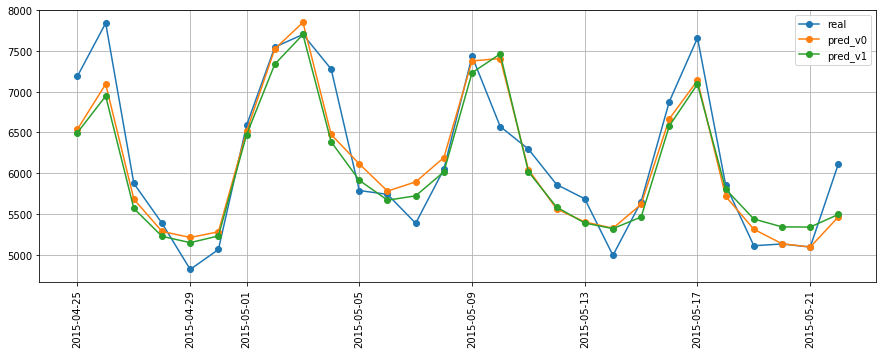

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Fitting the model
[0]	eval-wrmsseL12:1.16490
Will train until eval-wrmsseL12 hasn't improved in 200 rounds.
[25]	eval-wrmsseL12:0.76746
[50]	eval-wrmsseL12:0.76799
[75]	eval-wrmsseL12:0.76940
[100]	eval-wrmsseL12:0.77313
[125]	eval-wrmsseL12:0.77479
[150]	eval-wrmsseL12:0.77664
[175]	eval-wrmsseL12:0.77730
[200]	eval-wrmsseL12:0.77851
[225]	eval-wrmsseL12:0.77976
Stopping. Best iteration:
[32]	eval-wrmsseL12:0.76686

Elapsed time: 1.183016590277354 [min]
Predicting with ground thruth lagged values
Elapsed time: 0.0027083436648050944 [min]
wrmsse: 0.7668570396074347
Predicting with recursive approach
Elapsed time: 1.3593422611554464 [min]
wrmsse: 0.849936023408074


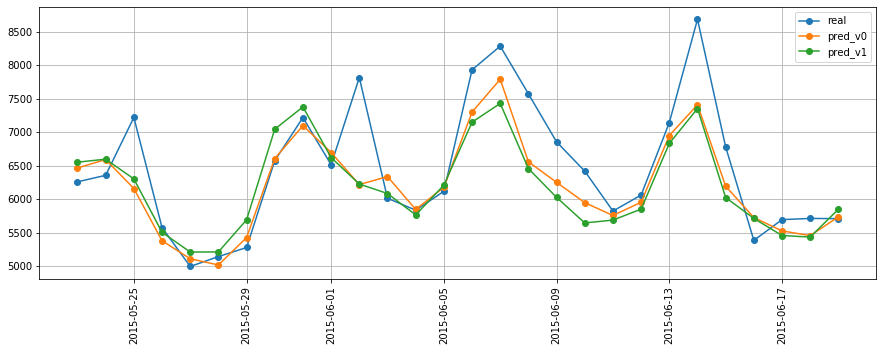

####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Fitting the model
[0]	eval-wrmsseL12:1.16563
Will train until eval-wrmsseL12 hasn't improved in 200 rounds.
[25]	eval-wrmsseL12:0.78448
[50]	eval-wrmsseL12:0.78687
[75]	eval-wrmsseL12:0.78888
[100]	eval-wrmsseL12:0.79161
[125]	eval-wrmsseL12:0.79317
[150]	eval-wrmsseL12:0.79479
[175]	eval-wrmsseL12:0.79570
[200]	eval-wrmsseL12:0.79741
Stopping. Best iteration:
[20]	eval-wrmsseL12:0.78344

Elapsed time: 1.2926694432894388 [min]
Predicting with ground thruth lagged values
Elapsed time: 0.002463821570078532 [min]
wrmsse: 0.783445312794224
Predicting with recursive approach
Elapsed time: 1.3926509857177733 [min]
wrmsse: 0.8253626213222053


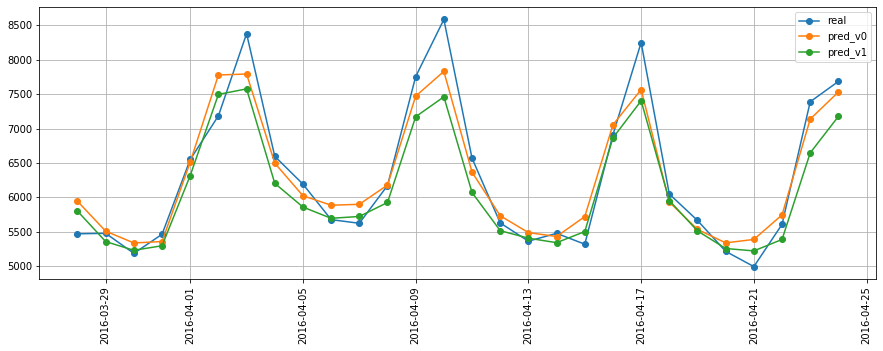

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
[0]	eval-wrmsseL12:1.12952
Will train until eval-wrmsseL12 hasn't improved in 200 rounds.
[25]	eval-wrmsseL12:0.74839
[50]	eval-wrmsseL12:0.75040
[75]	eval-wrmsseL12:0.75258
[100]	eval-wrmsseL12:0.75437
[125]	eval-wrmsseL12:0.75536
[150]	eval-wrmsseL12:0.75729
[175]	eval-wrmsseL12:0.75919
[200]	eval-wrmsseL12:0.76173
[225]	eval-wrmsseL12:0.76265
Stopping. Best iteration:
[28]	eval-wrmsseL12:0.74798

Elapsed time: 1.3789160291353861 [min]
Predicting with ground thruth lagged values
Elapsed time: 0.002603447437286377 [min]
wrmsse: 0.7479837234835482
Predicting with recursive approach
Elapsed time: 1.403097148736318 [min]
wrmsse: 0.8077488663506753


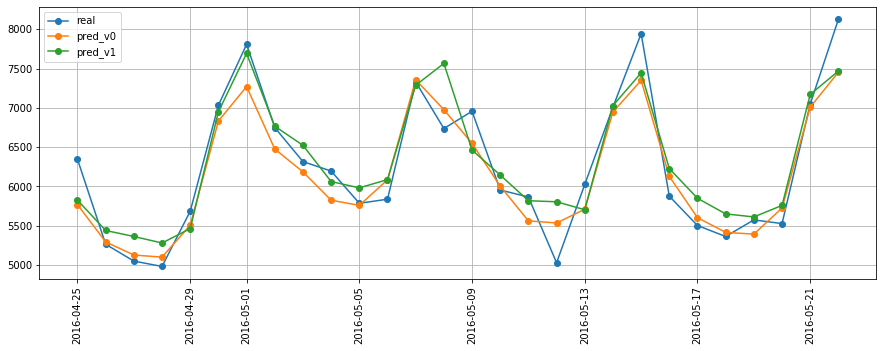

CPU times: user 2h 17min 42s, sys: 25min 21s, total: 2h 43min 3s
Wall time: 36min 16s


In [14]:
%%time
errors_v0 = dict()
errors_v1 = dict()

for i,valid_period in enumerate(valid_periods):

    print("#"*100)
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    logger.write("#"*100 + "\n")
    logger.write(f" Validation period: {valid_period} ".center(100, "#") + "\n")
    logger.write("#"*100 + "\n\n")

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    _train_data = data.query("ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    scales_level12 = compute_scaling(scaling_input, 
                                     cut_date=valid_start,
                                     agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)
    weights_level12 = compute_weights(weighting_input, 
                                      start_date=valid_start, level=12)
    
    # adds sample weights
    #_train_data = pd.merge(_train_data, weights_level12, how="left", on=["item_id","store_id"])
    #_train_data["weight"] /= _train_data["weight"].sum()
    #_train_data["weight"] *= 1./_train_data.weight.median()
    
    model_level12 = XGBoostForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index)
    model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
    ts_id_in_train = model_level12.train_features.ts_id.unique()
    model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

    # needed to remove leakage of 'no_stock' feature
    no_stock_ts = list()
    for threshold in [28, 56, 84, 112, 140, 168]:
        left_date = model_level12.train_features.ds.max() - pd.DateOffset(days=threshold)
        no_stock_ts.append((model_level12.train_features
                            .query("ds >= @left_date")
                            .groupby(["ts_id"])
                            .filter(lambda x: np.all(x.y==0))
                            .loc[:, ["ts_id"]]
                            .drop_duplicates()))
    model_level12.valid_features["no_stock"] = 0
    for j,no_stock in enumerate(no_stock_ts):
        idx = model_level12.valid_features.query("ts_id in @no_stock.ts_id").index
        model_level12.valid_features.loc[idx, "no_stock"] = j+1
        
    logger.write(f"- training samples: {len(model_level12.train_features)} \n\n")
    logger.write(f"- validation samples: {len(model_level12.valid_features)} \n\n")
    logger.write(f"- ts in train set: {model_level12.train_features.ts_id.nunique()} \n\n")
    logger.write(f"- ts in valid set: {model_level12.valid_features.ts_id.nunique()} \n\n")
    logger.write(f"- input_features: {model_level12.input_features} \n\n")
    logger.flush()
    
    print("Fitting the model")
    tic = time.time()
    evaluator = WRMSSEEvaluatorL12(model_level12.valid_features, weights_level12, scales_level12)
    model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    logger.write(f"- best_iteration: {model_level12.best_iteration} \n\n")
    logger.flush()

    #lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
    #lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))
    
    valid_dataframe = (model_level12.valid_features
                       .loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]]
                       .copy())
    evaluator = WRMSSEEvaluatorL12(valid_dataframe, weights_level12, scales_level12)

    print("Predicting with ground thruth lagged values")
    tic = time.time()
    forecast_v0 = (model_level12.valid_features
                   .loc[:, ["ds"]+model_level12.ts_uid_columns]
                   .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")

    wrmsse = evaluator._evaluate(forecast_v0.y_pred.values)
    errors_v0[f"f{i}"] = wrmsse
    print("wrmsse:", wrmsse)
    
    logger.write(f"- wrmsse approach 1: {wrmsse} \n\n")
    logger.flush()

    print("Predicting with recursive approach")
    tic = time.time()
    valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
    forecast_v1 = model_level12.predict(valid_data, recursive=True)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    wrmsse = evaluator._evaluate(forecast_v1.y_pred.values)
    errors_v1[f"f{i}"] = wrmsse
    print("wrmsse:", wrmsse)
    
    logger.write(f"- wrmsse approach 2: {wrmsse} \n\n")
    logger.flush()
    
    mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
           .merge(forecast_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
    plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()
    
    del model_level12, _train_data, _valid_index
    gc.collect()

In [15]:
# hasta aqui

***

In [16]:
approach1 = list(errors_v0.values())
approach2 = list(errors_v1.values())

logger.write("#"*100 + "\n")
logger.write(f" Overall ".center(100, "#") + "\n")
logger.write("#"*100 + "\n\n")

logger.write(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)} \n\n")
logger.write(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)} \n\n")
logger.flush()

In [17]:
print(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)}")
print(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)}")

- approach 1 on all folds: [0.7394371507953408, 0.7668570396074347, 0.783445312794224, 0.7479837234835482] - mean: 0.759430806670137
- approach 2 on all folds: [0.7705921627715802, 0.849936023408074, 0.8253626213222053, 0.8077488663506753] - mean: 0.8134099184631337


***